### Ilyes HAMDI

# Explainability Lab - Credit Risk

<img src=https://mma.prnewswire.com/media/1715842/HeadMind_Partners_Logo.jpg width="500">

<img src=https://www.centralesupelec.fr/sites/all/themes/cs_theme/medias/common/images/intro/logo.png width="500">

## Préambule: To read only if you use Goole Golab


1. Dans le dossier XAI_Evaluation vous allez trouver deux dossiers zippés: `data.zip` et `image.zip`
2. Dans Colab, ouvrir le panneau Fichiers (c'est-à-dire cliquez sur le logo en forme de dossier à gauche) et cliquez sur le premier bouton en haut à gauche vous permettant de télécharger. Téléchargez ainsi data.zip et image.zip dans votre colab. Si besoin actualiser jusqu'à voir l'archive apparaître dans le panneau. 
3.   Exécutez les deux cellules de code suivantes pour dézipper les deux archives. 

In [1]:
#Only if you use Google Colab

# !unzip data.zip

In [2]:
#Only if you use Google Colab

# !unzip image.zip

## Subject

*Context*

Credit risk is the risk that a customer doesn't pay back the money he borrowed from a bank. Banks do credit risk modelling to minimize their expected credit loss. ML models can be trained to classify whether a customer is at risk or not. (The banking sector is quite an early adopter of AI compared to other sectors). But banks have to comply with regulations that force them to provide models outputs with explanations that humans can understand.

*Dataset*

The German Credit Risk <a href="https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29"> dataset </a> is used.

The dataset is anonymized because it contains information about customer which is sensitive. The features are described in the data/features.txt file.

*Objectives*

- Dataset exploration : use seaborn to find relevant correlations
- ML implementation : train a Random Forest Classifier with Optuna 
- Explainability : global and local feature importance. Introduction to SHAP, LIME and ICE

*Notebook made by Headmind Partners AI & Blockchain*

## Libraries

In [3]:
# Do not forget to uncomment for the installation
# If you are on Google Colab do not forget to upload requirements.txt

# !pip install -r requirements.txt

In [4]:
import pickle
import shap
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score, plot_confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from scipy import stats
import optuna
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image
pd.set_option("display.max_columns", 500)

## Data Exploration

In [5]:
PATH = "data/credit-g.pkl"
#PATH= "./data/credit-g.pkl" for the Colab

with open(PATH, 'rb') as read_file:
    df = pickle.load(read_file)
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class,description
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,4,real estate,67,none,own,2,skilled,1,yes,yes,good,rpimcehosa
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,2,real estate,22,none,own,1,skilled,1,none,yes,bad,lzrdxtilff
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,3,real estate,49,none,own,1,unskilled resident,2,none,yes,good,uqhvkwayzt
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,4,life insurance,45,none,for free,1,skilled,2,none,yes,good,xoedxpdzgm
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,4,no known property,53,none,for free,2,skilled,2,none,yes,bad,yxyrmgoqzn


The goal is to predict if a bank can give a credit to a customer according to its profile

**Question 1:** Identify the target field

In [6]:
# Identify target field -- To complete
#########################
target_field = "class"
#########################

In [7]:
# Let's rename the target field
df.rename(columns={target_field:'risk'},inplace=True)
# And change the label values 
df['risk'] = df['risk'].map({'good':0,'bad':1})

y = df["risk"]
X = df.drop("risk", axis=1)

This is a binary classification problem where
-  y = 1 if the customer is at risk
-  y = 0 if the customer is "bankable"

In real life banks assess customer risk with more than two values (risky or not risky).

**Question 2:** In our case, what trick would you propose to get n risk values (with n>2) ? (with probabilities for instance)

--------------------------
**ANSWER HERE**

--------------------------

### Using seaborn to explore data 

Correlation matrixes and features distributions according to the credit risk are displayed using the *seaborn* library.

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

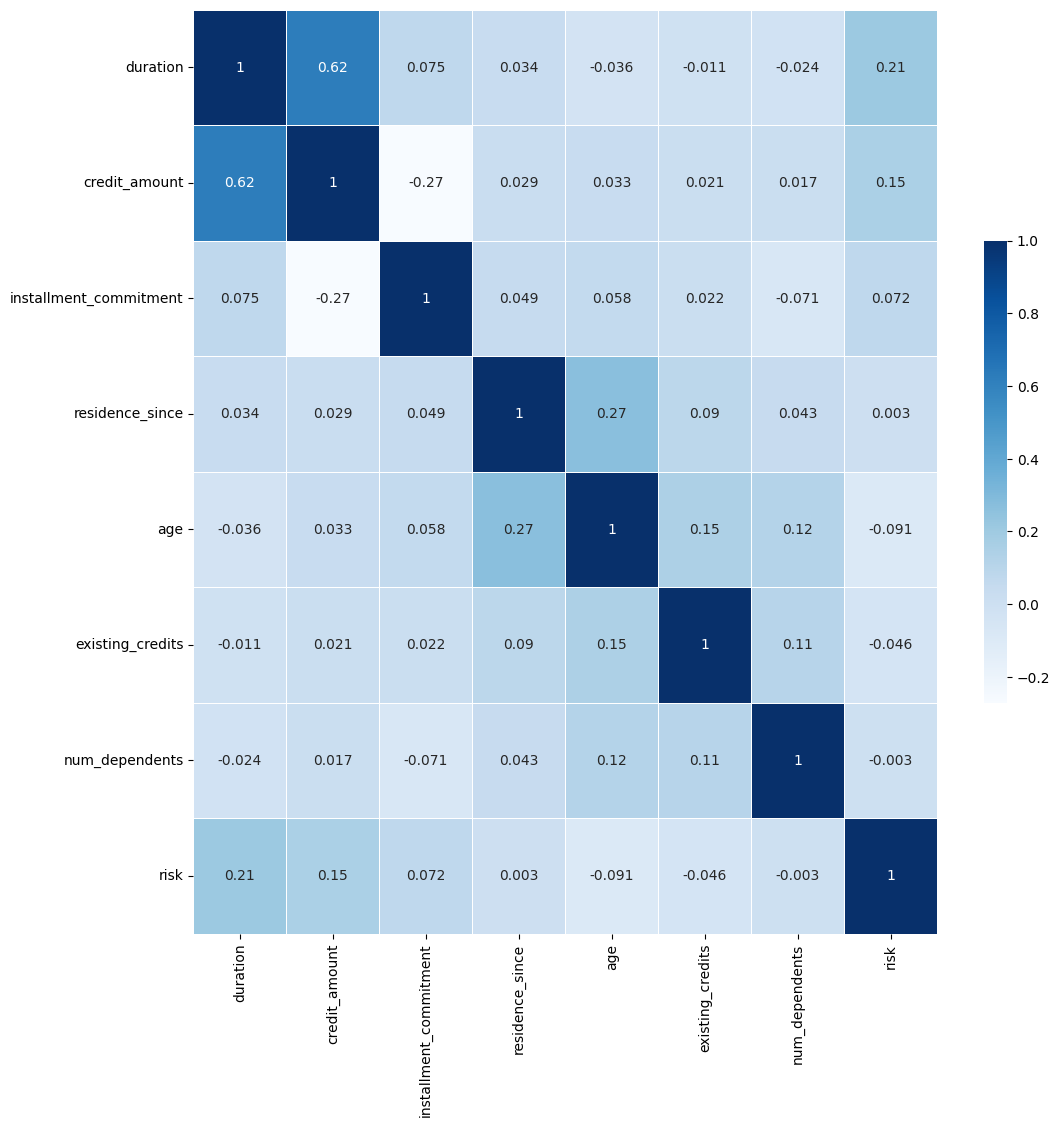

In [8]:
# Correlation matrix
corr = df.corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr, cmap="Blues", annot=True, linewidths=.5, cbar_kws={"shrink": .5})

<Axes: xlabel='age', ylabel='Density'>

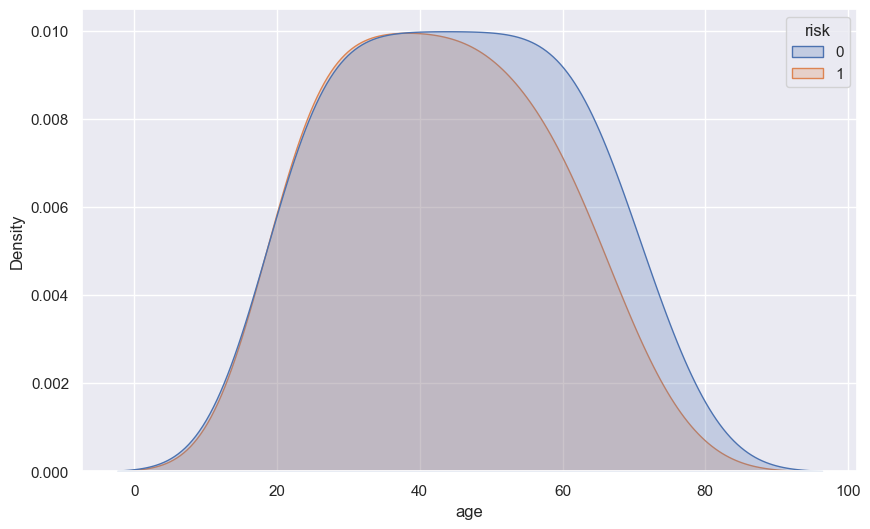

In [9]:
x = 'age'
plt.figure(figsize=(10,6))
sns.set_theme()
sns.kdeplot(data=df.groupby(x)["risk"].value_counts(normalize=True).mul(100), x=x, hue="risk", fill=True)

**Question 3:** Interpret this graph

--------------------------
ANSWER HERE
Ce graphique montre 2 points :
* Les 2 classes de "risk" sont répartis de la même façon par rapport à l'âge
* La classe des profils "bankable" est répartie de manière plus large par rapport à l'âge est comprend donc davantage de personne plus âgée
--------------------------

The dataset contains categorical features.

With a 2D plot, we can visualise the combination of a numerical feature and a categorical feature with respect to the target variable 'risk'.

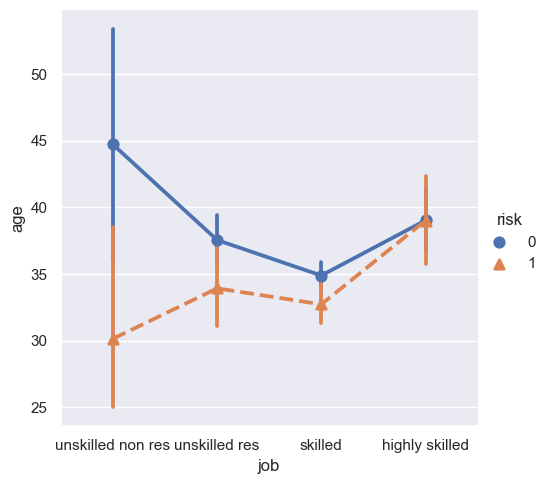

In [10]:
g = sns.catplot(
    data=df, x="job", y="age", hue="risk",
    markers=["o", "^"], linestyles=["-", "--"],
    kind="point",
    order = ['unemp/unskilled non res','unskilled resident','skilled','high qualif/self emp/mgmt'])
g.set_xticklabels(['unskilled non res', 'unskilled res', 'skilled','highly skilled'])

**Question 4:** Interpret the graph

--------------------------
ANSWER HERE
* On retrouve le fait que la courbe bleue des "bankable" est au-dessus de la courbe rouge
* Plus la personne est qualifiée et plus la différence d'âge est statistiquement petite entre les 2 catégories
--------------------------

## Encoding

Preliminary data exploration helped us discover all the features in the dataset, their distributions and correlations.

The categorical features now have to be encoded

**Question 5:** Complete the following code. 

In [11]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_feat = X.select_dtypes(include=numerics).columns.tolist()


##############################################
# Pick the right categorical features to encode
categorical_feat = [col for col in X.columns if col not in numeric_feat]

# Encode the features
one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit_transform categorical features
X_enc_array = one_hot_encoder.fit_transform(X[categorical_feat])

# Create a X_enc dataframe from the X_enc_array array
X_enc = pd.DataFrame(X_enc_array, columns=one_hot_encoder.get_feature_names(input_features=categorical_feat))

# Adds the numeric features
X_enc = pd.concat([X_enc, X[numeric_feat]], axis=1)

display(X_enc.head())
##############################################

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


,checking_status_0<=X<200,checking_status_<0,checking_status_>=200,checking_status_no checking,credit_history_all paid,credit_history_critical/other existing credit,credit_history_delayed previously,credit_history_existing paid,credit_history_no credits/all paid,purpose_business,purpose_domestic appliance,purpose_education,purpose_furniture/equipment,purpose_new car,purpose_other,purpose_radio/tv,purpose_repairs,purpose_retraining,purpose_used car,savings_status_100<=X<500,savings_status_500<=X<1000,savings_status_<100,savings_status_>=1000,savings_status_no known savings,employment_1<=X<4,employment_4<=X<7,employment_<1,employment_>=7,employment_unemployed,personal_status_female div/dep/mar,personal_status_male div/sep,personal_status_male mar/wid,personal_status_male single,other_parties_co applicant,other_parties_guarantor,other_parties_none,property_magnitude_car,property_magnitude_life insurance,property_magnitude_no known property,property_magnitude_real estate,other_payment_plans_bank,other_payment_plans_none,other_payment_plans_stores,housing_for free,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_none,own_telephone_yes,foreign_worker_no,foreign_worker_yes,description_aazsvspmut,description_abatekuofs,description_abbckzenec,description_acizfjknoe,description_acuzospmjs,description_aeevmiutkk,description_aehajjivvt,description_agpqxdbmpe,description_agxujztdsc,description_ahfmygdqxm,description_ahkaxpsdab,description_aidtepbymt,description_aivoooswll,description_aktgrgpned,description_akxkscbzzz,description_alqaqhtfre,description_amjakxbomm,description_amopjyhsys,description_anhawhlqhp,description_aoagddjduj,description_appeygjuqr,description_aqklppztsf,description_aribqjryso,description_arlzjkkaym,description_asmqvzgraj,description_astejimtxv,description_auopefhjrx,description_avuachoscp,description_avzpsujskm,description_awdtjxopmj,description_awnrnkvqms,description_aybxyakujm,description_ayhaflxefz,description_ayidsozfnc,description_aynkrtqokc,description_ayoucalocf,description_aypodvflzi,description_ayrcjfyzwo,description_azlprybqfp,description_azmkiszvdf,description_bazjzuvcou,description_bcasmnfbqb,description_bcetrgzzeb,description_bcmtqxpfhd,description_bdecmhphxe,description_bdmfpajwqf,description_bekdqrfbac,description_bewabjitov,description_bfveoktonl,description_bgnzyahdks,description_bhczuxchup,description_bhiczejdwb,description_bhrotyhnob,description_bhrvmlcixo,description_bjjhhddzuy,description_bkrbksanru,description_bkweqnbuzy,description_bliqymadxh,description_blkwadsejo,description_blldwetedy,description_bnnfmrtnvt,description_bogprmzkle,description_bpqohernej,description_bpwcpnemdf,description_bqqjgjyjar,description_brtsktuipe,description_brwhqaygjd,description_brwqjababm,description_btpyhnidds,description_buhfxbjmth,description_bvbwaxebuc,description_bvzfmxqyzd,description_bwclsfyjlb,description_bwspnajhdt,description_bxhjcdtjzr,description_bxmmvjnhkw,description_bxvczieair,description_bxymzihndc,description_bybfkgtmwu,description_bybjwlmmsj,description_byfazzaqyx,description_bykwlusrhh,description_byswjomxcy,description_caklmrcegq,description_cbtqseshcm,description_cbvwouqfsr,description_ccaykhfpdy,description_cciwzhcqmx,description_cdfgtxibph,description_cdvehzjqkc,description_cfhecofiky,description_cfpyrpthhq,description_cfsqvfnzdm,description_cgpfxgrrxa,description_cgyujpnlda,description_chghlerges,description_chgmoxshmm,description_ciyxxjnoix,description_cjcfjozqvx,description_cjexodklze,description_ckaqxmspre,description_ckfwqpfsmp,description_ckvmhhibbu,description_clzztnstmm,description_cmhchdubtu,description_cpcohfazmg,description_cprpilafrt,description_cpxtiuyske,description_cqeyiaaeuq,description_csjdnrqjws,description_ctkacysxow,description_ctynpklexh,description_ctyqzbglnw,description_cujixetcow,description_cuskfwnlab,description_cuxuclqkip,description_cvyeajjvwx,description_cwbrdiifoy,description_cwhlxd

## ML Modeling

### Train/test split

**Question 6 :** Split X and y to fit the model. Make sure the risk proportion in the train set are the same as in the test set using the argument *stratify*.

In [12]:
test_size = 0.2
# using stratify to keep the same proportion of class in the train and test set
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=test_size, random_state=42, stratify=y)

### Training a ML model
A Ramdom Forest is a right model to be trained on a small dataset (1000 rows)

#### Random Forest

**Question 7:** 

- Do you consider the dataset unbalanced ? 
- Compute the label proportion. 
- Do you think it is necessary to add class weight or sample weight ?

In [13]:
# label proportion in the train set
y_train.value_counts(normalize=True)

0    0.7
1    0.3
Name: risk, dtype: float64

In [14]:
# label proportion in the test set
y_test.value_counts(normalize=True)

0    0.7
1    0.3
Name: risk, dtype: float64

In [15]:
##############################
sample_weight = compute_sample_weight({0: 7, 1: 3}, y_train)
##############################

In [16]:
# Create and train the model
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train, sample_weight=sample_weight)
# rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Metrics
Let's compute the appropriate metrics to evaluate the model

In [17]:
from sklearn.metrics import roc_auc_score

y_pred = rf_clf.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_pred)

0.796547619047619

**Question 8 :**  

- Compare the metric score with sample_weight and without sample_weight. 
- Why sample_weight is so important when using a RandomForest ?

--------------------------
ANSWER HERE
* Score with sample weight : 0.80
* Score without : 0.81
* sample_weight est utilisé pour donner plus d'importance à des instances particulières parce qu'elles sont plus sûres que d'autres par exemple
* 
--------------------------

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


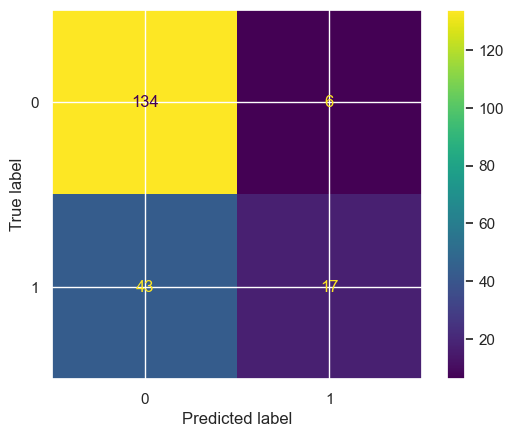

In [18]:
plot_confusion_matrix(rf_clf, X_test, y_test)

**Question 9 :** 

- Comment the confusion matrix for the Random Forest Classifier. 
- Compute the false negative rate. 
- How do you explain this rate compared to the good AUC score we obtained ?

--------------------------
ANSWER HERE
* P - 0 & N - 1
* In our goal, the FP is the thing we want to avoid. Its number here is not that low : 43.
* FN rate = fn/(fn+tp) = 5/(5+135) = 3.6 %
* AUC represents the area under the ROC curve
--------------------------

**Question 10 :** Compute the precision and recall for the risky class (1).

In [19]:
###############
#To complete
tp, fn, fp, tn = 135, 5, 43, 17

# compute precision for class 1
precision = tp/(tp+fp)
# compute recall for class 1
recall = tp/(tp+fn)
###############
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Precision: 0.76
Recall: 0.96


**Question 11 : Ethic.**

- Control the proportion of risk in the input dataset for the given feature : personal_status, age. For the feature *age*, transform it to a boolean feature *age < 30*. For the personal_status feature, study the case of women vs. men.
- Control the proportion of risk in the prediction dataset for the same categories.
- Did ML model increase or decrease the existing bias in the input dataset ? 
- Did the model predict more risks than the input for the considered features ? 

In [20]:
# Input Dataset control -- To complete

df["age < 30"] = df["age"] < 30

# compute the proportion of risk in the input dataset for category age < 30
prop_input_risk_age_below_30 = df[(df["age < 30"]) & (df["risk"] == 1)].shape[0]/df[df["age < 30"]].shape[0]

# compute the proportion of risk in the input dataset for category age >= 30
prop_input_age_over_30 = df[(~df["age < 30"]) & (df["risk"] == 1)].shape[0]/df[~df["age < 30"]].shape[0]

print("proportion risk below 30 yo : ", prop_input_risk_age_below_30)
print("proportion risk over 30 yo : ", prop_input_age_over_30)

print("Categories personal_status : ", df["personal_status"].unique())

df["is_woman"] = df['personal_status'] == 'female div/dep/mar'
prop_input_risk_woman = df[(df['is_woman']) & (df["risk"] == 1)].shape[0]/df[df["is_woman"]].shape[0]
prop_input_risk_man = df[(~df['is_woman']) & (df["risk"] == 1)].shape[0]/df[~df["is_woman"]].shape[0]

print("proportion risk for woman : ", prop_input_risk_woman)
print("proportion risk for man : ", prop_input_risk_man)

proportion risk below 30 yo :  0.3692722371967655
proportion risk over 30 yo :  0.2591414944356121
Categories personal_status :  ['male single' 'female div/dep/mar' 'male div/sep' 'male mar/wid']
proportion risk for woman :  0.35161290322580646
proportion risk for man :  0.2768115942028985


In [21]:
for c in X_test.columns:
    if 'personal' in c:
        print(c)

personal_status_female div/dep/mar
personal_status_male div/sep
personal_status_male mar/wid
personal_status_male single


In [22]:
X_test['personal_status_female div/dep/mar'].value_counts()

0.0    139
1.0     61
Name: personal_status_female div/dep/mar, dtype: int64

In [23]:
# Prediction dataset control
# Note that we can compare the input risk proportion with the test set risk proportion
# because we used the stratify argument in the train_test_split

X_test_ethic = X_test.copy()
y_pred_class = rf_clf.predict(X_test)
X_test_ethic["risk_predicted"] = y_pred_class

# compute the proportion of risk in the dataset for category age < 30
X_test_ethic["age < 30"] = X_test_ethic["age"] < 30
prop_pred_age_below_30 = X_test_ethic[(X_test_ethic["age < 30"]) & (X_test_ethic["risk_predicted"] == 1)].shape[0]/X_test_ethic[X_test_ethic["age < 30"]].shape[0]
prop_pred_age_over_30 = X_test_ethic[(~X_test_ethic["age < 30"]) & (X_test_ethic["risk_predicted"] == 1)].shape[0]/X_test_ethic[~X_test_ethic["age < 30"]].shape[0]

print("proportion risk below 30 yo : ", prop_pred_age_below_30)
print("proportion risk over 30 yo : ", prop_pred_age_over_30)

# after one-hot-encoding
X_test_ethic["is_woman"] = X_test['personal_status_female div/dep/mar'] == 1
# compute the proportion of risk in the dataset for category is_woman 
prop_pred_risk_woman = X_test_ethic[(X_test_ethic["is_woman"]) & (X_test_ethic["risk_predicted"] == 1)].shape[0]/X_test_ethic[X_test_ethic["is_woman"]].shape[0]
prop_pred_risk_man = X_test_ethic[(~X_test_ethic["is_woman"]) & (X_test_ethic["risk_predicted"] == 1)].shape[0]/X_test_ethic[~X_test_ethic["is_woman"]].shape[0]


print("proportion risk for woman : ", prop_pred_risk_woman)
print("proportion risk for man : ", prop_pred_risk_man)

proportion risk below 30 yo :  0.1518987341772152
proportion risk over 30 yo :  0.09090909090909091
proportion risk for woman :  0.13114754098360656
proportion risk for man :  0.1079136690647482


In [24]:
# Comparison proportions in input and predictions
# prop_input_risk_age_below_30, prop_pred_age_below_30
print('age below 30 : ', prop_input_risk_age_below_30, prop_pred_age_below_30)
# prop_input_age_over_30, prop_pred_age_over_30
print('age over 30 : ', prop_input_age_over_30, prop_pred_age_over_30)
# prop_input_risk_woman, prop_pred_risk_woman
print('woman : ', prop_input_risk_woman, prop_pred_risk_woman)
# prop_input_risk_man, prop_pred_risk_man
print('man : ', prop_input_risk_man, prop_pred_risk_man)

age below 30 :  0.3692722371967655 0.1518987341772152
age over 30 :  0.2591414944356121 0.09090909090909091
woman :  0.35161290322580646 0.13114754098360656
man :  0.2768115942028985 0.1079136690647482


--------------------------
ANSWER HERE
* The values decrease significantly
--------------------------

## Explainability - Feature importance 

### Global Explainability
Global explanations are useful for understanding what a model finds important, as well as identifying potential flaws in its decision making

#### SHAP values
<a href="https://christophm.github.io/interpretable-ml-book/shapley.html">Shapley values</a> are common coefficients to quantify the contributions of each features in the predictions of the model. Theoretically, *coalitions* are made to observe the influence of a selected feature in the prediction. The contribution is computed by comparing the predictions with and without this feature.

The computation can take a while, especially on large dataset. The contribution computation is thus often made on random subsets.

In [25]:
clf_shap_values = shap.TreeExplainer(rf_clf, X_test)
shap_values = clf_shap_values.shap_values(X_test, check_additivity=False)

 98%|===================| 390/400 [00:12<00:00]        

Let's quantify the feature contribution to the output

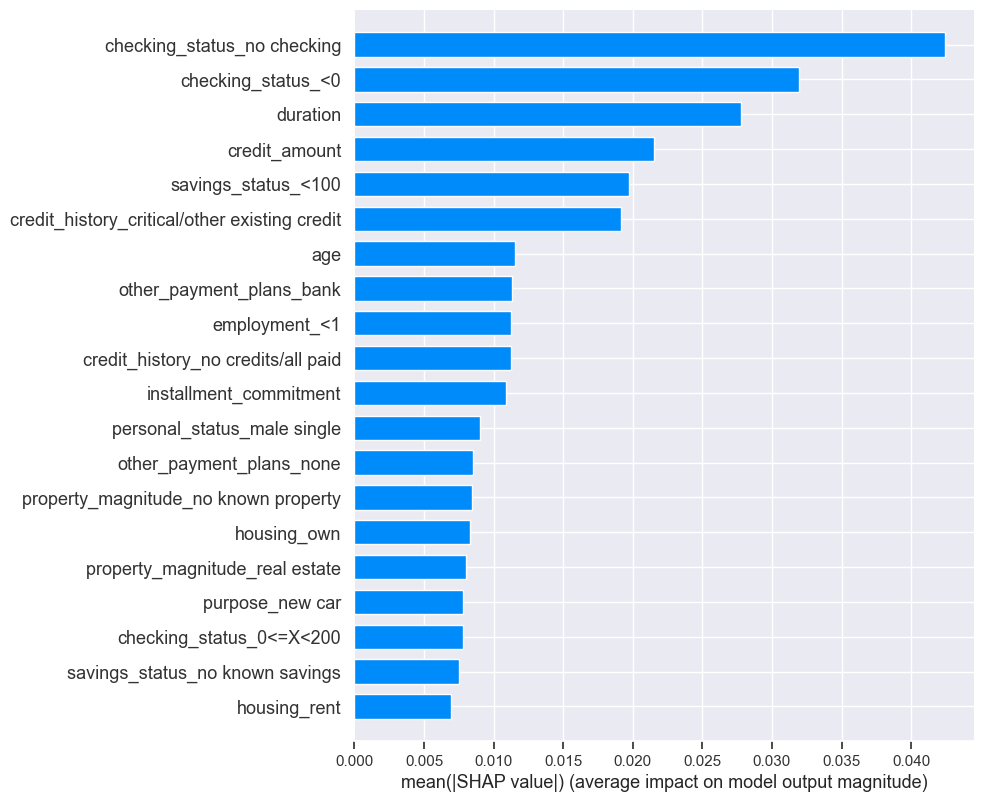

In [26]:
shap.summary_plot(shap_values[1], features=X_test, feature_names = X_enc.columns, plot_type='bar')

**Question 12**: Interpret the graph

--------------------------
ANSWER HERE
* Except from duration and age, only encoded categorical features appear on the graph with the most important variables
* The first variables are financial variables, it's quite satisfying to see this
--------------------------

In [27]:
"""
Attention
Attention
Attention
Le code de cette cellule tue le kernel en local mais je ne sais pas pourquoi et l'intervenant non plus.
"""

# Code here a solution to get the importance of non-encoded features
####################
print(numeric_feat)
X_test_num = X_test[numeric_feat]
# clf_shap_values_num = shap.TreeExplainer(rf_clf, X_test_num)
# shap_values_num = clf_shap_values_num.shap_values(X_test_num, check_additivity=False)
# shap.summary_plot(shap_values_num[1], features=X_test_num, feature_names = numeric_feat, plot_type='bar')

####################

['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']


We can also see in which direction a feature influences the output

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


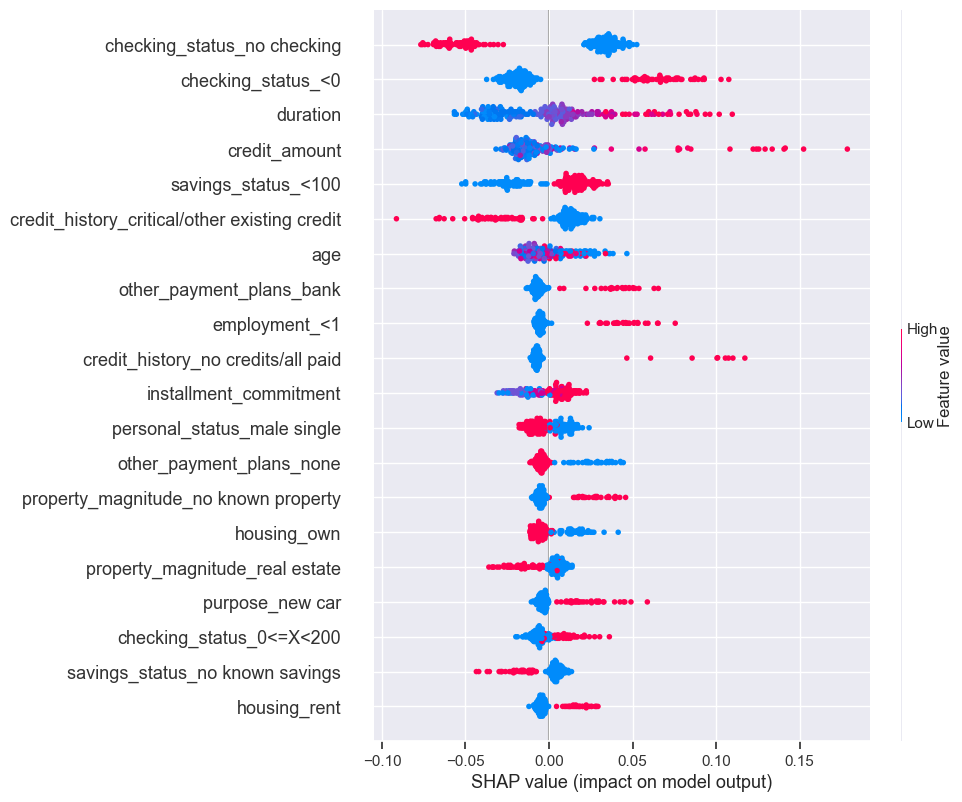

In [28]:
shap.summary_plot(shap_values[1], features=X_test, feature_names=X_enc.columns, plot_type="dot")

**Question 13:** What can you say about this plot ? (hint: Remember the correlations in exploration part)

--------------------------
ANSWER HERE
* Ici on a l'importance de chaque variable en fonction de si elle prend de grandes ou de petites valeurs
* la variable âge est intéressante : le rouge et le bleu se marie bien
* une variable est importante lorsqu'elle a de grandes valeurs de shapley
* une variable est également importante lorsqu'elle vient avec une différence notable entre les valeurs faibles et les valeurs hautes prises par la variable
* on observe même que les variables credit_amount et duration qui sont très corrélées ont une distribution très similaire de valeurs de shapley
--------------------------

#### Permutation
Permutation is about shuffling a column, so that its contribution to the output is somehow eliminated. 

Permutation importance explains the contribution of a feature to the model accuracy

In [29]:
# Compute permutation importance
imp = permutation_importance(rf_clf,X_test,y_test,scoring="roc_auc",
        n_repeats=10,
        max_samples=min(2000, X_test.shape[0]))["importances_mean"]
imp = pd.Series(imp, index=list(X_test.columns))
# Sort contribution
imp.sort_values(inplace=True, ascending=False)

imp

checking_status_no checking             0.050810
checking_status_<0                      0.028542
duration                                0.028292
credit_amount                           0.014351
savings_status_<100                     0.011708
                                          ...   
own_telephone_yes                      -0.003393
other_payment_plans_bank               -0.004744
employment_1<=X<4                      -0.005524
property_magnitude_no known property   -0.007482
credit_history_existing paid           -0.007542
Length: 1061, dtype: float64

In [37]:
imp[:20]

checking_status_no checking                      0.050810
checking_status_<0                               0.028542
duration                                         0.028292
credit_amount                                    0.014351
savings_status_<100                              0.011708
age                                              0.011327
purpose_new car                                  0.010333
credit_history_no credits/all paid               0.007012
purpose_used car                                 0.006649
installment_commitment                           0.006607
personal_status_female div/dep/mar               0.005720
purpose_radio/tv                                 0.004595
housing_own                                      0.004113
savings_status_no known savings                  0.003994
other_parties_none                               0.003857
property_magnitude_life insurance                0.003655
property_magnitude_car                           0.003500
credit_history

**Question 14:** Did you observe any difference between permutation importance and SHAP?

--------------------------
ANSWER HERE
* we observe that the first variables are the same
* Yes, there are some differences. The first one is for credit_history_critical/other existing credit which is considered less important with permutation importance.
* Out of 20 variables shown, there are 13 in common with a another order.
--------------------------

### Local explainability
Local explanations show how a single prediction is made

#### Counterfactuals

A *counterfactual* is a sample with a different target class than the *factual* sample considered.
A counterfactual explanation of a prediction describes the smallest change to the feature values that changes the prediction to a predefined output. 

**Question 15:** Choose a method to compute a similarity score between two single samples. 

We will then apply this function to a factual example and one of its counterfactuals

In [30]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

numeric_feat = X.select_dtypes(include=numerics).columns.tolist()
oh_features = one_hot_encoder.get_feature_names_out()
scl = StandardScaler()
scl.fit(X[numeric_feat])

def similarity(fact, counterfact):
    # numerical similarity
    num_sim = cosine_similarity(fact[numeric_feat], counterfact[numeric_feat])
    # categorical similarity
    cat_sim = cosine_similarity(fact[oh_features], counterfact[oh_features])
    return (num_sim + cat_sim)/2

**Question 16:** Pick a random sample with risk prediction

In [44]:
### CODE HERE ###
import random
random_sample_with_risk = X.iloc[random.sample([i for i in (y == 1).index], 1)[0]]

**Question 17:** find two counter-factuals with more than 90% similarity. If no counterfactuals reach 90% similarity, display the counterfactuals with the maximum similarity.

In [45]:
###################
counterfactuals = []
for i in range(X.shape[0]):
    counterfact = X.iloc[i]
    if rf_clf.predict(counterfact) != 1:
        sim = similarity(random_sample_with_risk,counterfact)
        if sim > 0.9:
            counterfactuals.append(counterfact)
    if len(counterfactuals) == 2:
        break
print(len(counterfactuals))
###################

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


ValueError: could not convert string to float: '<0'

--------------------------
ANSWER HERE

--------------------------

#### ICE

ICE is short for Individual Conditional Expectation

ICE is an intuitive method. For a given individual, it shows on a plot how the model's prediction changes with a feature varying across a set of values

Below is an example

In [33]:
Image(url="image/ICE.png",width=500,height=400)

**Question 18:** Code a function that plots ICE for a feature given as input

In [34]:
def ICE(feat):
    ###############
    #To complete

    return True
    ###############

#### LIME
<a href="https://medium.com/dataman-in-ai/explain-your-model-with-lime-5a1a5867b423">LIME</a> stands for Local Interpretable Model-Agnostic Explanations.


In [35]:
Image(url="image/LIME.png",width=800,height=400)

## 3 steps:


1. generate samples
2. weight the samples according to their distance to the sample to explain
3. Train a smaller model on the weighted samples




In [36]:
# Randomize categorical features
categories_dict = defaultdict(list)
oh_features = one_hot_encoder.get_feature_names_out()
for feat_name in oh_features:
    key, value = feat_name.rsplit("_",1)
    categories_dict[key].append(value)
n = 200
random_categories = []
for key,value in categories_dict.items():
    frequencies = df[key].value_counts(normalize=True)
    random_categories.append(np.random.choice(frequencies.index,n,p=frequencies.values))
random_samples_sparse = one_hot_encoder.transform(pd.DataFrame(np.array(random_categories).T,columns = categorical_feat))
random_samples_enc = pd.DataFrame(random_samples_sparse, columns = oh_features)

# Randomize continuous features
# Approximating every variable distribution using gaussian kde
kernel = stats.gaussian_kde(df[numeric_feat].values.T)
random_samples_enc[numeric_feat] = kernel.resample(n, seed = 0).T

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [ ]:
# Select a sample to explain and encode it

#### CHOOSE SAMPLE HERE ####
sample = df.loc[200:200]
############################

sample_sparse = one_hot_encoder.transform(sample[categorical_feat])
sample_enc = pd.DataFrame(sample_sparse.toarray(), columns = oh_features)
sample_enc[numeric_feat] = sample[numeric_feat].values

In [ ]:
#Compute the weights
alpha = 1.5

# Scale the numerical features to avoid bias on larger features
scl = StandardScaler()
scl.fit(df[numeric_feat])
def similarities(random_samples,sample):
    # numerical similarity
    num_sim = cosine_similarity(scl.transform(random_samples[numeric_feat]),scl.transform(sample[numeric_feat]))
    # categorical similarity
    cat_sim = cosine_similarity(random_samples[oh_features],sample[oh_features])
    return (num_sim + cat_sim)/2

weights = np.exp(alpha*similarities(random_samples_enc,sample_enc))

In [ ]:
# Train simplified models with those samples and weights

tree_clf = tree.DecisionTreeClassifier(max_depth=3,random_state=0)
tree_clf = tree_clf.fit(random_samples_enc,rf_clf.predict(random_samples_enc),weights.reshape(-1))

In [ ]:
plt.figure(figsize=(15,10))
_ = tree.plot_tree(tree_clf, feature_names=sample_enc.columns,label="none",impurity = False,precision=2,rounded=True,class_names=["good","bad"])

**Question 19 :** 

- How can you compare the feature importances based on this decision tree ?
- Run again the LIME Experiment on the same sample. What can you tell about the stability of the plot tree ?
- Run the experiment for a sample with risk prediction and compare the decision tree explainability with the other explainability methods.

--------------------------
ANSWER HERE

--------------------------

In [ ]:
### CODE HERE ###

### Extra: Feature selection for model's improvements

Now that the feature importances have been computed, select the decisive features in order to improve the baseline of the previous Ramdom Forest Classifier model


We use Optuna to run hyperparameters optimizations for the model chosen. To correctly use Optuna you need :




- A ML model

- an *objective* function with *trial* as argument.

    - Specify the hyperparameters to optimize (e.g. n_estimators for a Ramdom Forest Classifier)

    - Returns the score of the new training. This score needs either to be minimized (loss) or maximized (metric)




You'll find below an example for the Optuna implementation.




**A sample weight is recommended when implementing a RandomForestClassifier.** When it comes to XGBoost, it will not be necessary (because corrective weights are assigned during the training process).




The score chosen in the hyperparameters research is decisive. Please keep in mind that we are dealing with classification.
The Optuna objective function and the study to optimize the hyperparameters are shown in the couple cells below. As mentioned above, a sample weight is computed to weight the loss function during the training.


In [ ]:
def objective_rf(trial):
    rf_params = {
            # Parameter space definition
            #################################################################
            'n_estimators' : trial.suggest_int('n_estimators',low=1,high=10)
            #...
            #################################################################
            }

    rf_classifier = RandomForestClassifier(random_state=42)
    rf_classifier.set_params(**rf_params)
    rf_classifier.fit(X_train, y_train,sample_weight=sample_weight)
    y_pred = rf_classifier.predict(X_test)
    score=roc_auc_score(y_test, y_pred)
    return score

In [ ]:
study = optuna.create_study(direction="maximize")
full_objective = lambda trial: objective_rf(trial)
study.optimize(full_objective, n_trials=60, timeout=600)
rf_params = study.best_trial.params